In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
from IPython.display import display
import stumpy
import os
import zipfile
from tqdm.notebook import tqdm_notebook
from datetime import datetime

np.set_printoptions(suppress=True)

data_directory = './data/Feb2022/' # The root directory for where all the data files are stored
overall_filename = 'february_data.csv' # Filename where the concatenated individual files will be stored

In [12]:
# Helper functions. They do what the function name suggests

def read_in_file(filename, keep_columns=None, drop_columns=None, time_format='%Y-%m-%dT%H:%M:%S.%f'):
    '''Reads in a .csv file into a Pandas DataFrame. 
    
    This function assumes there is a column in the .csv whose name is 'time'. The 'time' column is automatically set as a
    Pandas DatetimeIndex.

    Args:
        filename : str
            The name of the file to be read from, in .csv format.
        keep_columns : list str
            The names of the columns to keep from the file. If None, all columns will be kept.
        drop_columns: list str
            The names of the columns to drop from the file. If None, it will not be used.
        time_format: str
            The datetime format for which to parse the 'time' column from the .csv file. 

    Returns:
        A Pandas DataFrame.
    '''
    df = pd.read_csv(filename)

    if 'time' in df.columns.tolist():
        df.time = pd.to_datetime(df.time, format=time_format)

    df = df.set_index('time')

    if keep_columns is not None:
        df = df[keep_columns]

    if drop_columns is not None:
        df = df.drop(columns=drop_columns)

    return df

def groupby_second(df, agg='mean'):
    '''@param df: pandas DataFrame with index as a DateTimeIndex'''
    df = df.groupby(by=[df.index.year, df.index.month, df.index.day, df.index.hour, df.index.minute, df.index.second]).agg(agg)
    df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
                df.index.get_level_values(1).astype(str) + '-' +
                df.index.get_level_values(2).astype(str) + 'T' +
                df.index.get_level_values(3).astype(str) + ':' +
                df.index.get_level_values(4).astype(str) + ':' +
                df.index.get_level_values(5).astype(str),
                format='%Y-%m-%dT%H:%M:%S')
    return df

def do_matrix_profile_nd(df, m):
    mps, indices = stumpy.mstump(df, m)
    motifs_idx = np.argsort(mps, axis=1)[:, 0]
    nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(18,5*df.shape[1]))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='8')
        axs[k].plot(np.arange(df.shape[0]), df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='8')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='8')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='8')

        # axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        # if dim_name != 'T3':
        #     axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        #     axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        #     axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
        # else:
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        #     axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

    plt.show()

def do_matrix_profile_1d(df, m):
    mp = stumpy.stump(df.iloc[:, 0], m)
    discord_idx = np.argsort(mp[:, 0])[-1]
    nearest_neighbor_distance = mp[discord_idx, 0]

    fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(18,8))
    plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='12')

    axs[0].plot(df.iloc[:, 0].values)
    axs[0].set_ylabel(list(df.columns)[0], fontsize='12')
    rect = Rectangle((discord_idx, 0), m, max(df.iloc[:, 0]), facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='12')
    axs[1].set_ylabel('Matrix Profile', fontsize='12')
    axs[1].axvline(x=discord_idx, linestyle="dashed")
    axs[1].plot(mp[:, 0])
    plt.show()

def do_matrix_profile(df, m, t1=None, t2=None, impute=False):
    '''@param m: the window or kernel size for the matrix profile'''

    if t1 is not None \
        and t2 is not None \
        and t1 < t2:
        df = df[(df.index >= t1) & (df.index < t2)]

    if impute:
        if df.isnull().values.any():
            df.fillna(df.mean())

    if len(df.columns) > 1: # If you have more than one dimension
        do_matrix_profile_nd(df, m)
    else:
        do_matrix_profile_1d(df, m)


def plot_time_window(df, t1, t2, col, impute=False):
    df = df[(df.index >= t1) & (df.index < t2)]

    if impute:
        if df.isnull().values.any():
            df.fillna(df.mean())

    sns.lineplot(x=df.index, y=df[col])
    plt.show()

In [3]:
# Utility class for zipping/unzipping archives

class Zipper():
    def zip_one_file(self, file, archive):
        with zipfile.ZipFile(archive, "w", zipfile.ZIP_DEFLATED) as zf:
            zf.write(file)

    def zip_files(self, files, archives):
        for i, file in enumerate(files):
            self.zip_one_file(file, archives[i])

    def unzip_one_archive(self, archive, out_dir=None):
        with zipfile.ZipFile(archive, 'r') as zf:
            info = zf.infolist()
            file = info[0]
            zf.extract(file, out_dir)

In [4]:
# Run this cell if you need to extract all the data files from data_directory + 'zip/'

archive_directory = data_directory + 'zip/'
out_dir = data_directory

archives = [archive_directory + file for file in os.listdir(archive_directory)]

for archive in archives:
    Zipper().unzip_one_archive(archive, out_dir)

In [8]:
# Run this cell if you need to concatenate all the data files from data_directory into a csv grouped by second

out_file = 'february_data_by_second.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files

    if ".csv" not in file:
        continue
    
    df = read_in_file(data_directory + file)
    df = groupby_second(df)
    df.dropna(inplace=True)

    if len(df) > 0:
        if i == 0:
            df.to_csv(out_file)
        else:
            df.to_csv(out_file, mode='a', header=False)

  0%|          | 0/310 [00:00<?, ?it/s]

In [4]:
# Run this cell if you need to concatenate all the data files from data_directory into a csv

out_file = 'february_data.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files

    if ".csv" not in file:
        continue
    
    df = read_in_file(data_directory + file)

    if len(df) > 0:
        if i == 0:
            df.to_csv(out_file)
        else:
            df.to_csv(out_file, mode='a', header=False)

  0%|          | 0/310 [00:00<?, ?it/s]

In [ ]:
'''
TODO: 
    compare different startup-to-stop windows
    document code
    make poster
'''

Start of Matrix Profile Analysis

In [5]:
src_file = 'february_data.csv'

df_overall = pd.read_csv(src_file)
df_overall.time = df_overall.time.astype(str)
df_overall.set_index(pd.to_datetime(df_overall.time, errors='coerce'), drop=True, inplace=True)
df_overall.drop(columns=['time'], inplace=True)

In [6]:
t1 = datetime(year=2022, 
              month=2, 
              day=20, 
              hour=14, 
              minute=16, 
              second=0)
t2 = datetime(year=2022,
              month=2, 
              day=20, 
              hour=14, 
              minute=46, 
              second=0)

cols = ['Continuous Bond Vibration']
window_sizes = range(60, 300, 60)

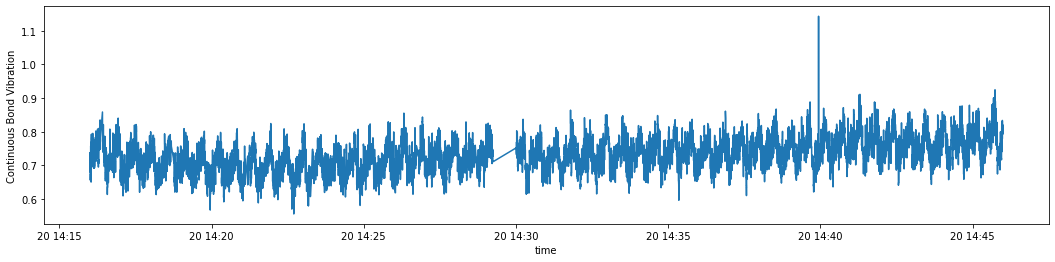

In [13]:
figure(figsize=(18,4))
plot_time_window(df_overall, t1, t2, cols[0], impute=True)

Window size (m): 1.0


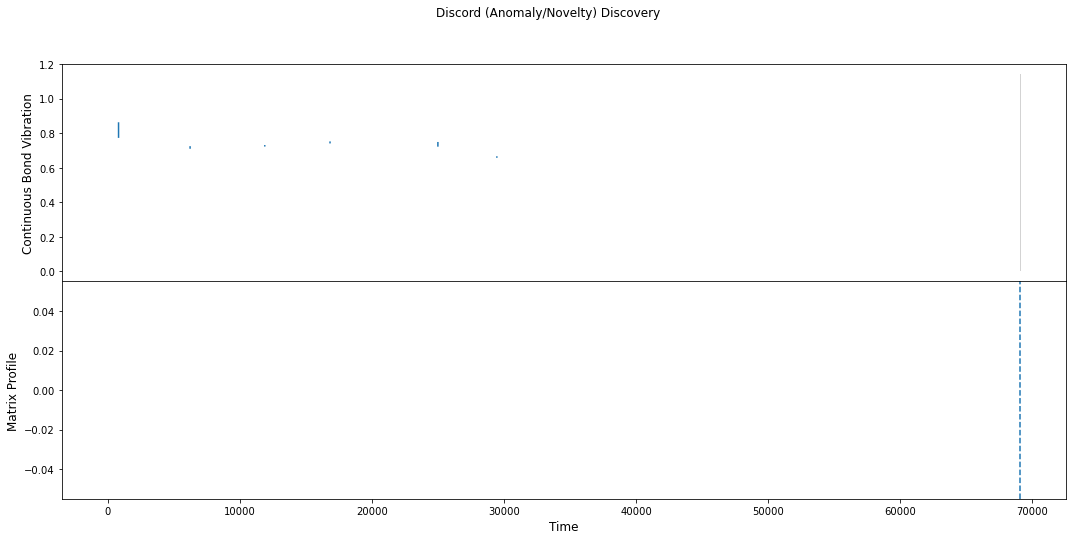

Window size (m): 2.0


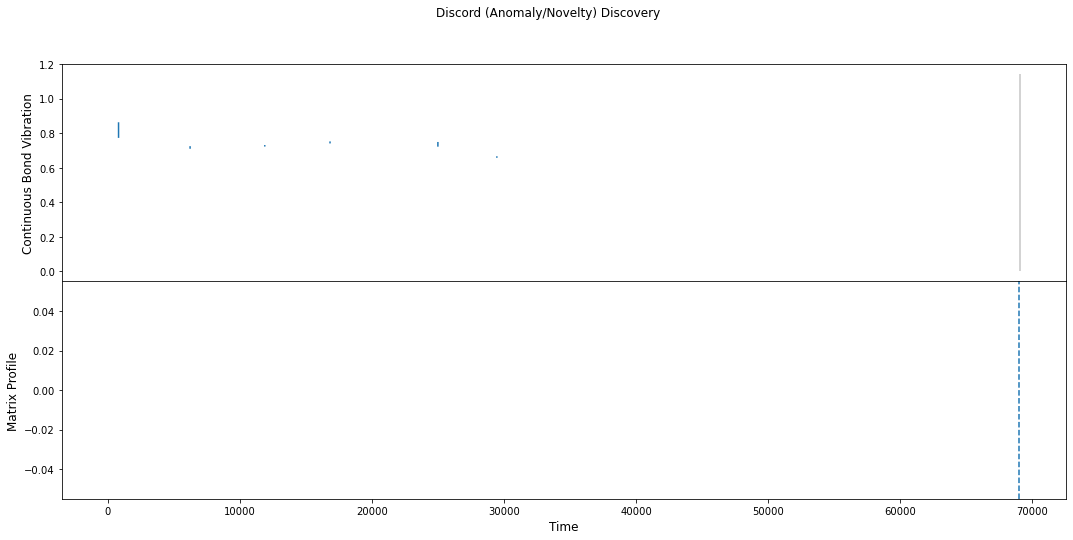

Window size (m): 3.0


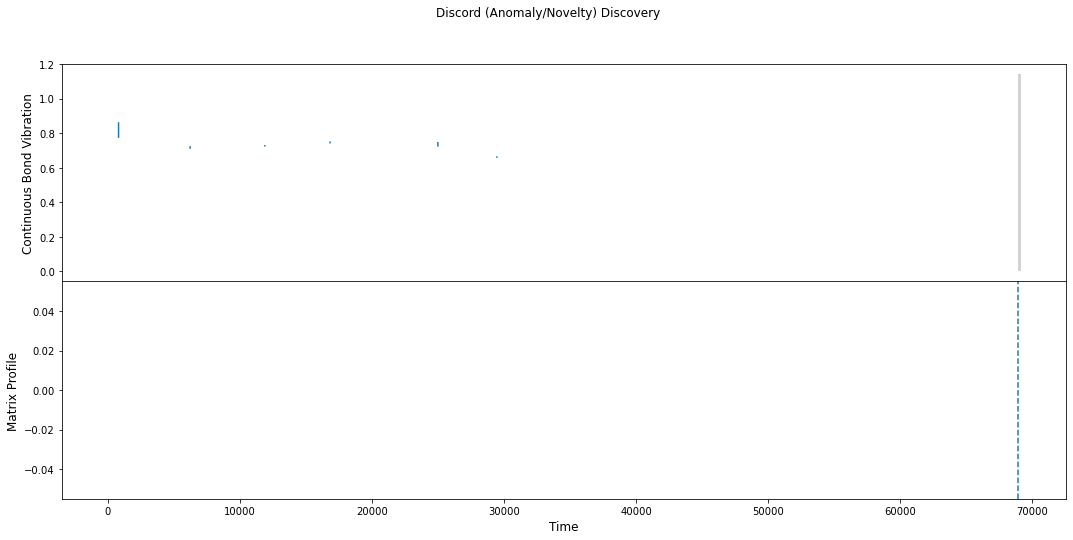

Window size (m): 4.0


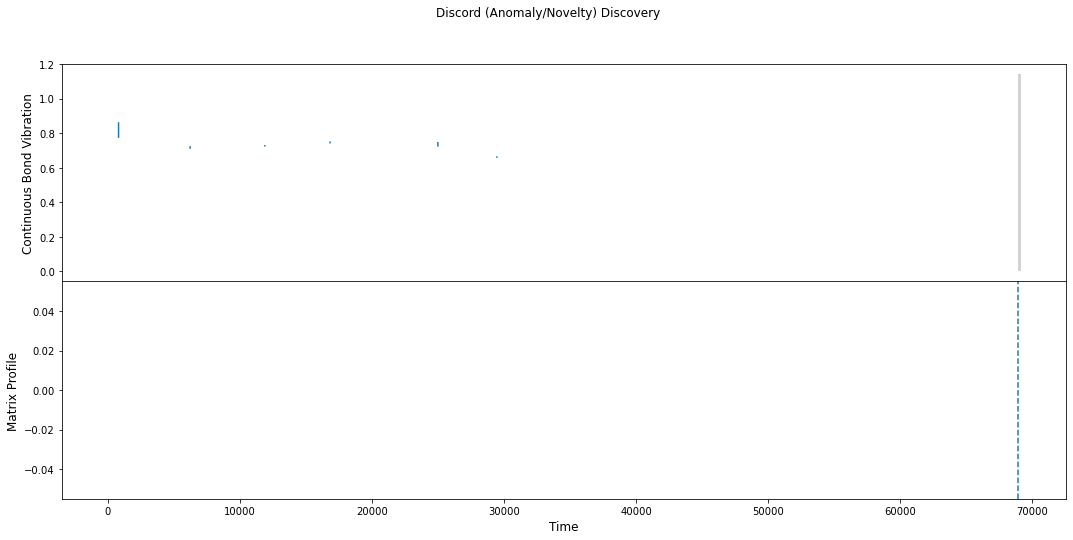

In [14]:
for m in window_sizes:
    print("Window size (m): {}".format(m/60), flush=False)
    do_matrix_profile(df_overall[cols], m, t1, t2, impute=True)